In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import patsy

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse, meanabs

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
released_2019 = pd.read_csv('released_2019.csv')
del released_2019['Unnamed: 0']
released_2019 = released_2019[['Weeks_on_chart' ,'Song_title', 'Artist', 'Peak_rank', 'Artist_list',
       'Artist_count', 'Collab', 'Artist_query', 'Song_and_artist',
       'Feature_dict', 'Release_date', 'Duration_ms', 'Id', 'Popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo', 'valence']]

released_2019

Weeks_on_chart                    Song_title  \
0                 1                     1, 2 Many   
1                11                  10,000 Hours   
2                15                         223's   
3                 1                3 Headed Snake   
4                 1                           365   
..              ...                           ...   
443              21         You Need To Calm Down   
444               7  You Should See Me In A Crown   
445               4                      You Stay   
446               3             homecoming queen?   
447               1                        iPHONE   

                                                Artist  Peak_rank  \
0                           Luke Combs & Brooks & Dunn         97   
1                           Dan + Shay & Justin Bieber          4   
2                                YNW Melly & 9lokknine         34   
3                           Gunna Featuring Young Thug         74   
4                                    Zedd & Katy Perry         86   
..                                                 ...        ...   
443                                       Taylor Swift          2   
444                                      Billie Eilish         41   
445  DJ Khaled Featuring Meek Mill, J Balvin, Lil B...         44   
446                                   Kelsea Ballerini         82   
447                               DaBaby & Nicki Minaj         43   

                                           Artist_list  Artist_count  Collab  \
0                     ['Luke Combs', 'Brooks', 'Dunn']             3    True   
1                      ['Dan + Shay', 'Justin Bieber']             2    True   
2                           ['YNW Melly', '9lokknine']             2    True   
3                              ['Gunna', 'Young Thug']             2    True   
4                               ['Zedd', 'Katy Perry']             2    True   
..                                                 ...           ...     ...   
443                                   ['Taylor Swift']             1   False   
444                                  ['Billie Eilish']             1   False   
445  ['DJ Khaled', 'Meek Mill', 'J Balvin', 'Lil Ba...             5    True   
446                               ['Kelsea Ballerini']             1   False   
447                          ['DaBaby', 'Nicki Minaj']             2    True   

                 Artist_query  \
0           Luke Combs Brooks   
1    Dan + Shay Justin Bieber   
2         YNW Melly 9lokknine   
3            Gunna Young Thug   
4             Zedd Katy Perry   
..                        ...   
443              Taylor Swift   
444             Billie Eilish   
445       DJ Khaled Meek Mill   
446          Kelsea Ballerini   
447        DaBaby Nicki Minaj   

                                       Song_and_artist  \
0                 1, 2 Many Luke Combs & Brooks & Dunn   
1              10,000 Hours Dan + Shay & Justin Bieber   
2                          223's YNW Melly & 9lokknine   
3            3 Headed Snake Gunna Featuring Young Thug   
4                                365 Zedd & Katy Perry   
..                                                 ...   
443                 You Need To Calm Down Taylor Swift   
444         You Should See Me In A Crown Billie Eilish   
445  You Stay DJ Khaled Featuring Meek Mill, J Balv...   
446                 homecoming queen? Kelsea Ballerini   
447                        iPHONE DaBaby & Nicki Minaj   

                                          Feature_dict  ... energy  key  \
0    {'tracks': {'href': 'https://api.spotify.com/v...  ...  0.821    6   
1    {'tracks': {'href': 'https://api.spotify.com/v...  ...  0.630   10   
2    {'tracks': {'href': 'https://api.spotify.com/v...  ...  0.547    0   
3    {'tracks': {'href': 'https://api.spotify.com/v...  ...  0.415    6   
4    {'tracks': {'href': 'https://api.spotify.com/v...  ...  0.693    2   
..                                

In [3]:
released_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 448 entries, 0 to 447
Data columns (total 25 columns):
Weeks_on_chart      448 non-null int64
Song_title          448 non-null object
Artist              448 non-null object
Peak_rank           448 non-null int64
Artist_list         448 non-null object
Artist_count        448 non-null int64
Collab              448 non-null bool
Artist_query        448 non-null object
Song_and_artist     448 non-null object
Feature_dict        448 non-null object
Release_date        448 non-null object
Duration_ms         448 non-null int64
Id                  448 non-null object
Popularity          448 non-null int64
danceability        448 non-null float64
energy              448 non-null float64
key                 448 non-null int64
loudness            448 non-null float64
mode                448 non-null int64
speechiness         448 non-null float64
acousticness        448 non-null float64
instrumentalness    448 non-null float64
liveness          

In [4]:
released_2019.describe()

Weeks_on_chart   Peak_rank  Artist_count    Duration_ms  Popularity  \
count      448.000000  448.000000    448.000000     448.000000  448.000000   
mean         7.359375   54.022321      1.622768  195561.243304   76.790179   
std          8.677047   28.452393      0.973069   42059.224867    8.843187   
min          1.000000    1.000000      1.000000   49292.000000   53.000000   
25%          1.000000   31.750000      1.000000  168929.750000   71.000000   
50%          3.000000   57.000000      1.000000  192326.000000   76.000000   
75%         11.250000   78.000000      2.000000  218801.750000   83.000000   
max         45.000000  100.000000     10.000000  362653.000000  100.000000   

       danceability      energy         key    loudness        mode  \
count    448.000000  448.000000  448.000000  448.000000  448.000000   
mean       0.692199    0.622123    5.189732   -6.234225    0.593750   
std        0.150091    0.155777    3.640707    2.205502    0.491681   
min        0.238000    0.111000    0.000000  -15.044000    0.000000   
25%        0.595750    0.524000    1.000000   -7.442250    0.000000   
50%        0.704500    0.630000    5.000000   -5.894000    1.000000   
75%        0.802250    0.734750    8.000000   -4.667250    1.000000   
max        0.978000    0.956000   11.000000   -1.996000    1.000000   

       speechiness  acousticness  instrumentalness    liveness       tempo  \
count   448.000000    448.000000        448.000000  448.000000  448.000000   
mean      0.152942      0.225118          0.008528    0.173647  122.291616   
std       0.126683      0.234934          0.053270    0.130079   31.102706   
min       0.025100      0.000143          0.000000    0.029400   62.446000   
25%       0.050150      0.041300          0.000000    0.099025   95.995750   
50%       0.096050      0.136500          0.000000    0.128500  120.065500   
75%       0.241000      0.334500          0.000007    0.204000  145.056750   
max       0.564000      0.978000          0.661000    0.913000  207.476000   

          valence  
count  448.000000  
mean     0.483221  
std      0.209584  
min      0.036100  
25%      0.328500  
50%      0.463500  
75%      0.622250  
max      0.962000

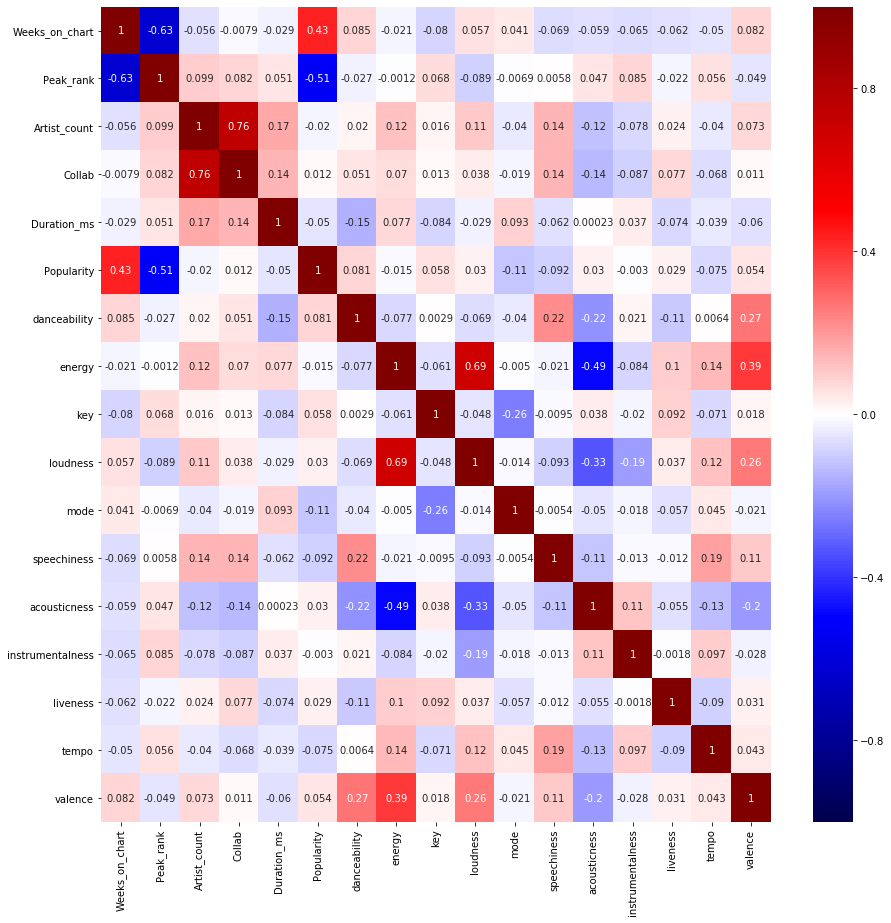

In [5]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(released_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

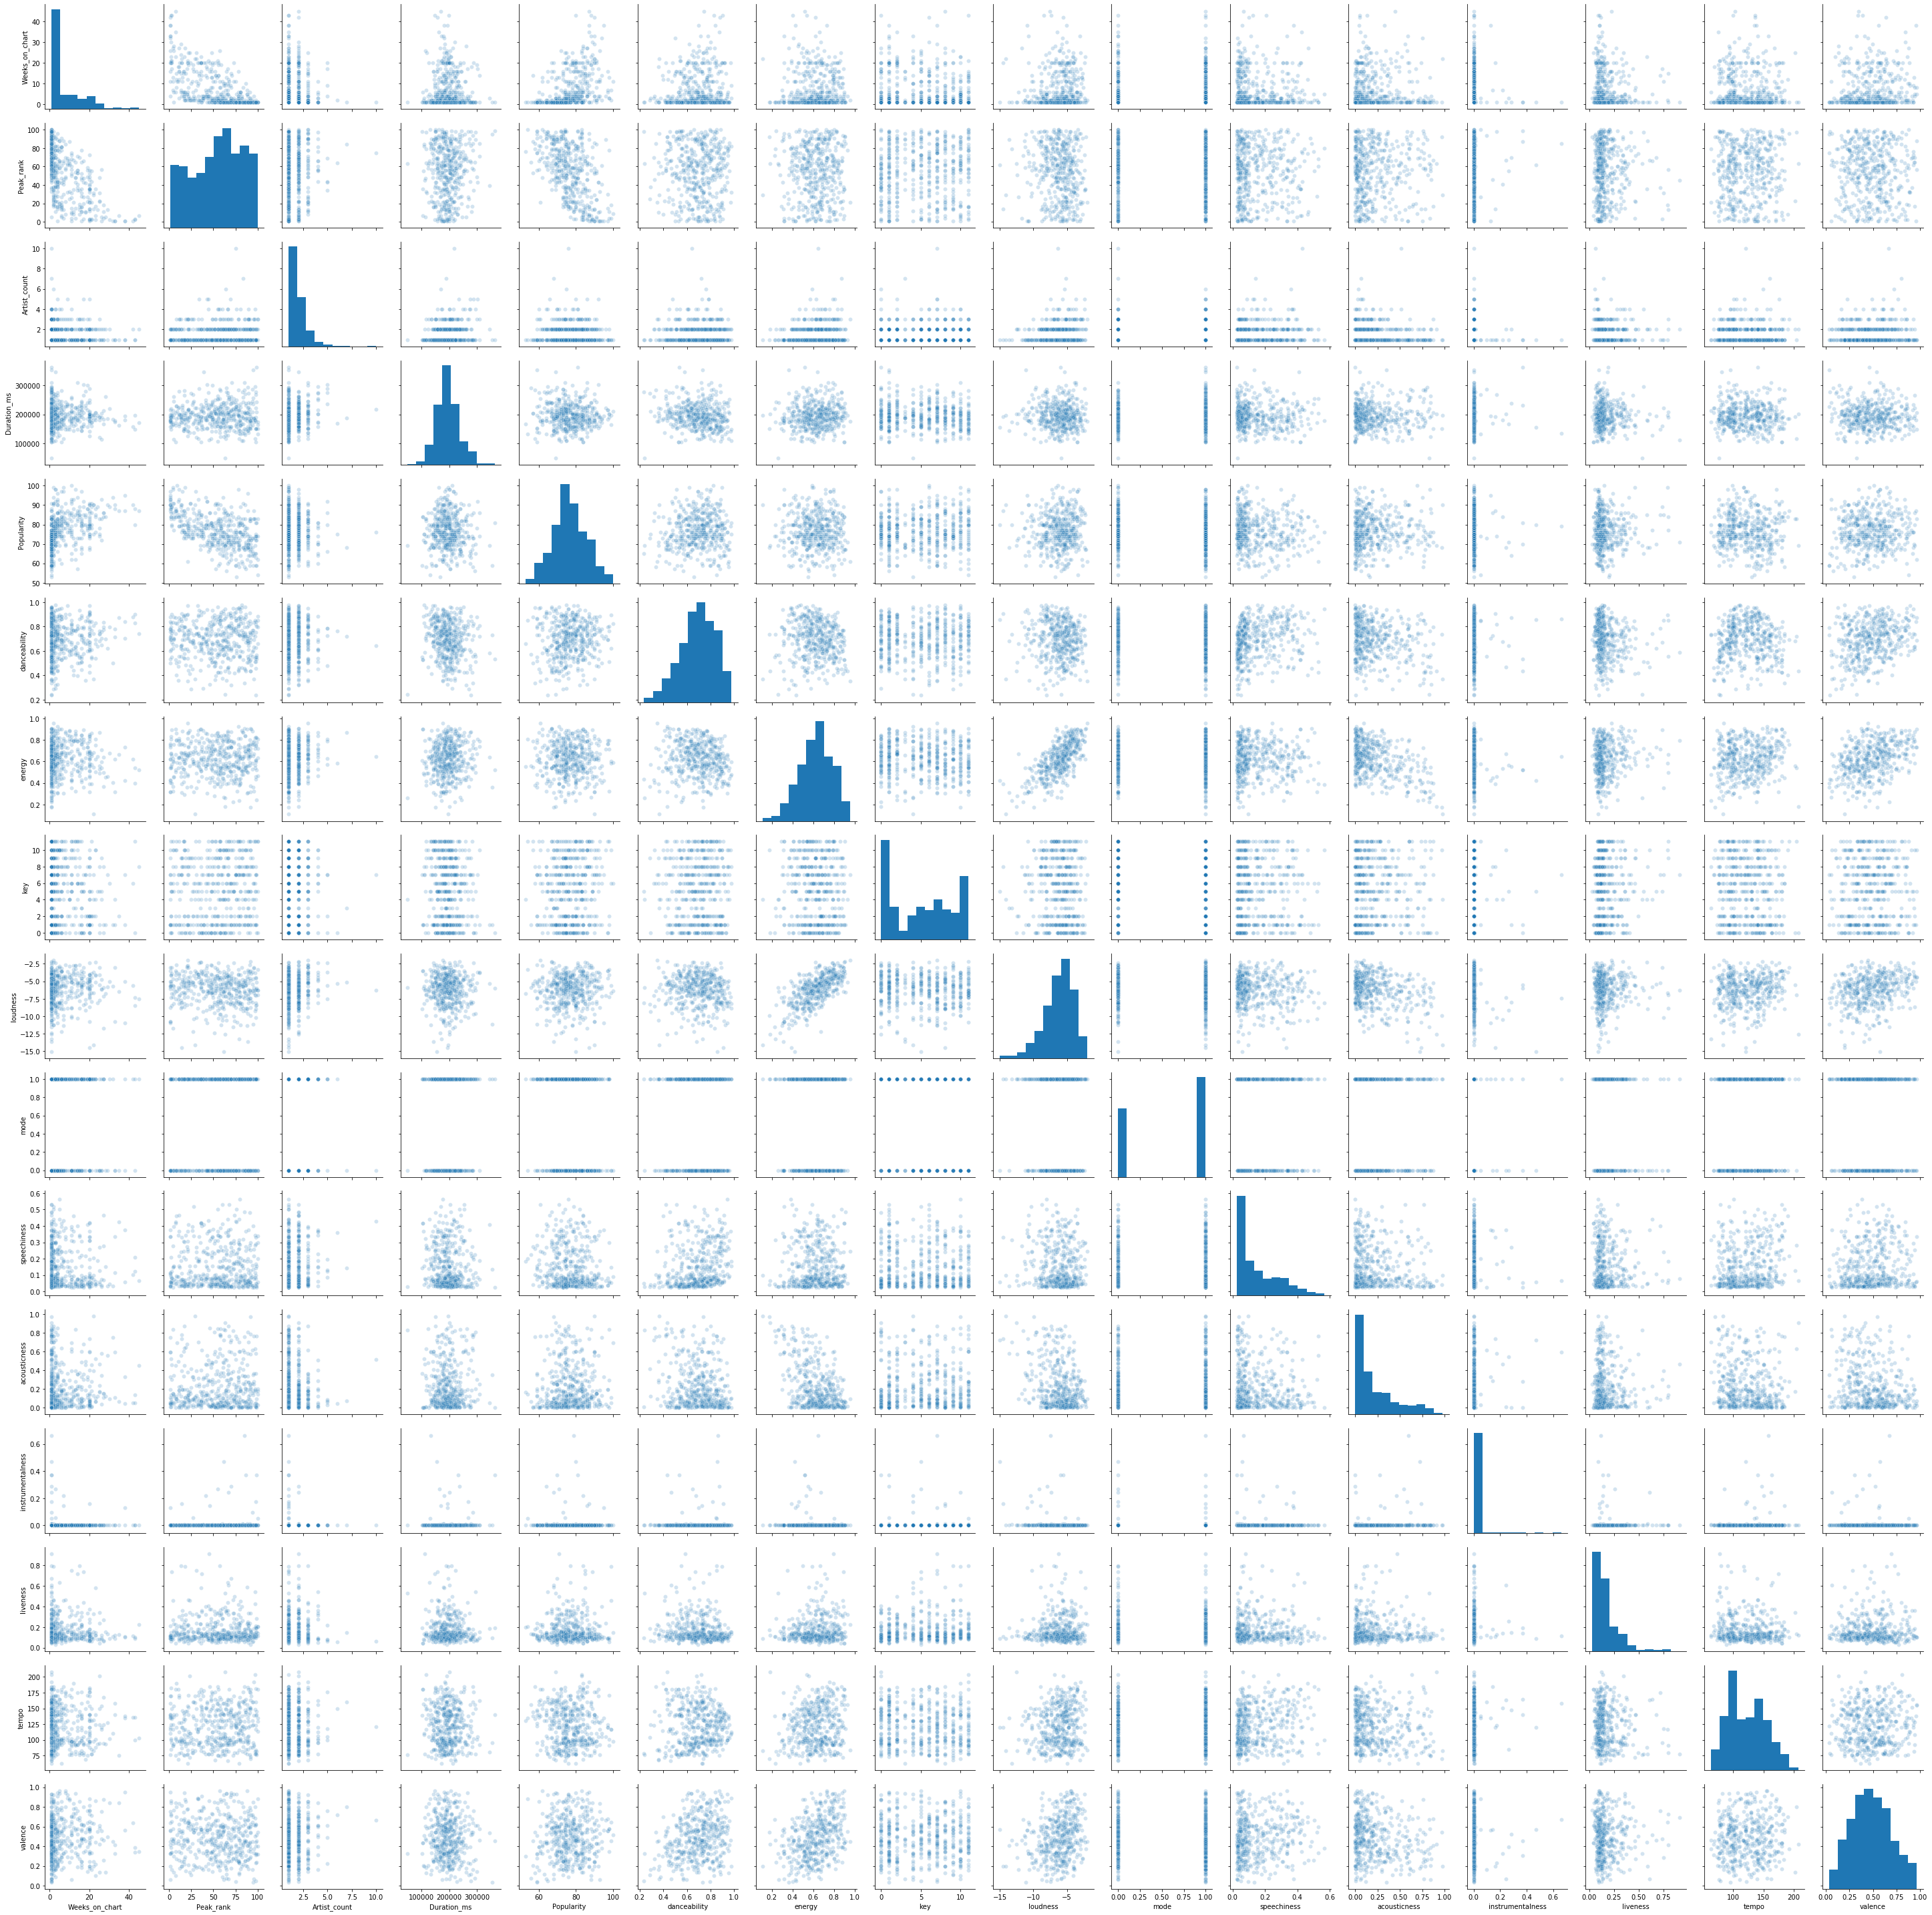

In [6]:
sns.pairplot(released_2019.drop(columns='Collab'), plot_kws={'alpha': 0.2}) #dropping collabs, sns doesn't like bools

In [7]:
released_2019.columns

Index(['Weeks_on_chart', 'Song_title', 'Artist', 'Peak_rank', 'Artist_list',
       'Artist_count', 'Collab', 'Artist_query', 'Song_and_artist',
       'Feature_dict', 'Release_date', 'Duration_ms', 'Id', 'Popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo', 'valence'],
      dtype='object')

Okay, this is a LOT of info.  But let's give it a run just to see where we are right now.

In [8]:
' + '.join(released_2019.columns)

'Weeks_on_chart + Song_title + Artist + Peak_rank + Artist_list + Artist_count + Collab + Artist_query + Song_and_artist + Feature_dict + Release_date + Duration_ms + Id + Popularity + danceability + energy + key + loudness + mode + speechiness + acousticness + instrumentalness + liveness + tempo + valence'

And let's pull anything that's not text or bools (regressions don't do well with bools for some reason)

In [9]:
mask = released_2019[['Weeks_on_chart', 'Peak_rank',
       'Artist_count', 'Duration_ms', 'Popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'tempo', 'valence']]

y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_rank + Artist_count + 
                          Duration_ms + Popularity + danceability + energy + key + loudness + 
                          mode + speechiness + acousticness + instrumentalness + liveness + 
                          tempo + valence''',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())

print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     21.81
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           5.11e-44
Time:                        23:55:31   Log-Likelihood:                -1476.9
No. Observations:                 448   AIC:                             2986.
Df Residuals:                     432   BIC:                             3051.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.0962      5.445  

#bigmeh.  Let's adjust a few parameters.

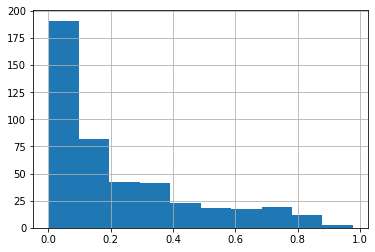

In [10]:
released_2019['acousticness'].hist()

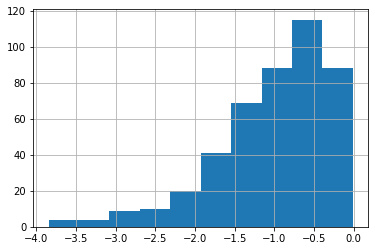

In [11]:
(np.log10(released_2019['acousticness'])).hist()

That's a little more normal, I'd say

In [12]:
released_2019['acousticness_log10'] = np.log10(released_2019['acousticness'])

Speechiness also suffers from the same fate, so we can apply the same treatment.

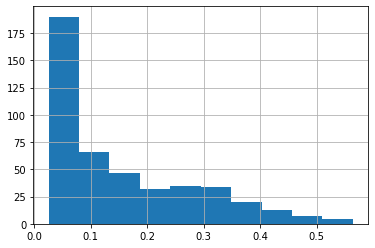

In [13]:
released_2019['speechiness'].hist()

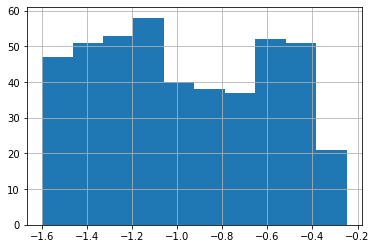

In [14]:
(np.log10(released_2019['speechiness'])).hist()

In [15]:
released_2019['speechiness_log10'] = np.log10(released_2019['speechiness'])

Duration in ms is also not the most useful, so let's run a conversion to minutes.

In [16]:
released_2019['Duration_min'] = released_2019['Duration_ms']/1000/60

I also want to invert peak placement to offset the sort of backwards effect of that metric (smaller peak = higher placement).

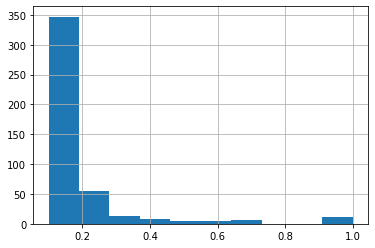

In [17]:
((1/released_2019['Peak_rank'])**.5).hist()

In [18]:
released_2019['Peak_coeff'] = ((1/released_2019['Peak_rank'])**.5)

pulse check

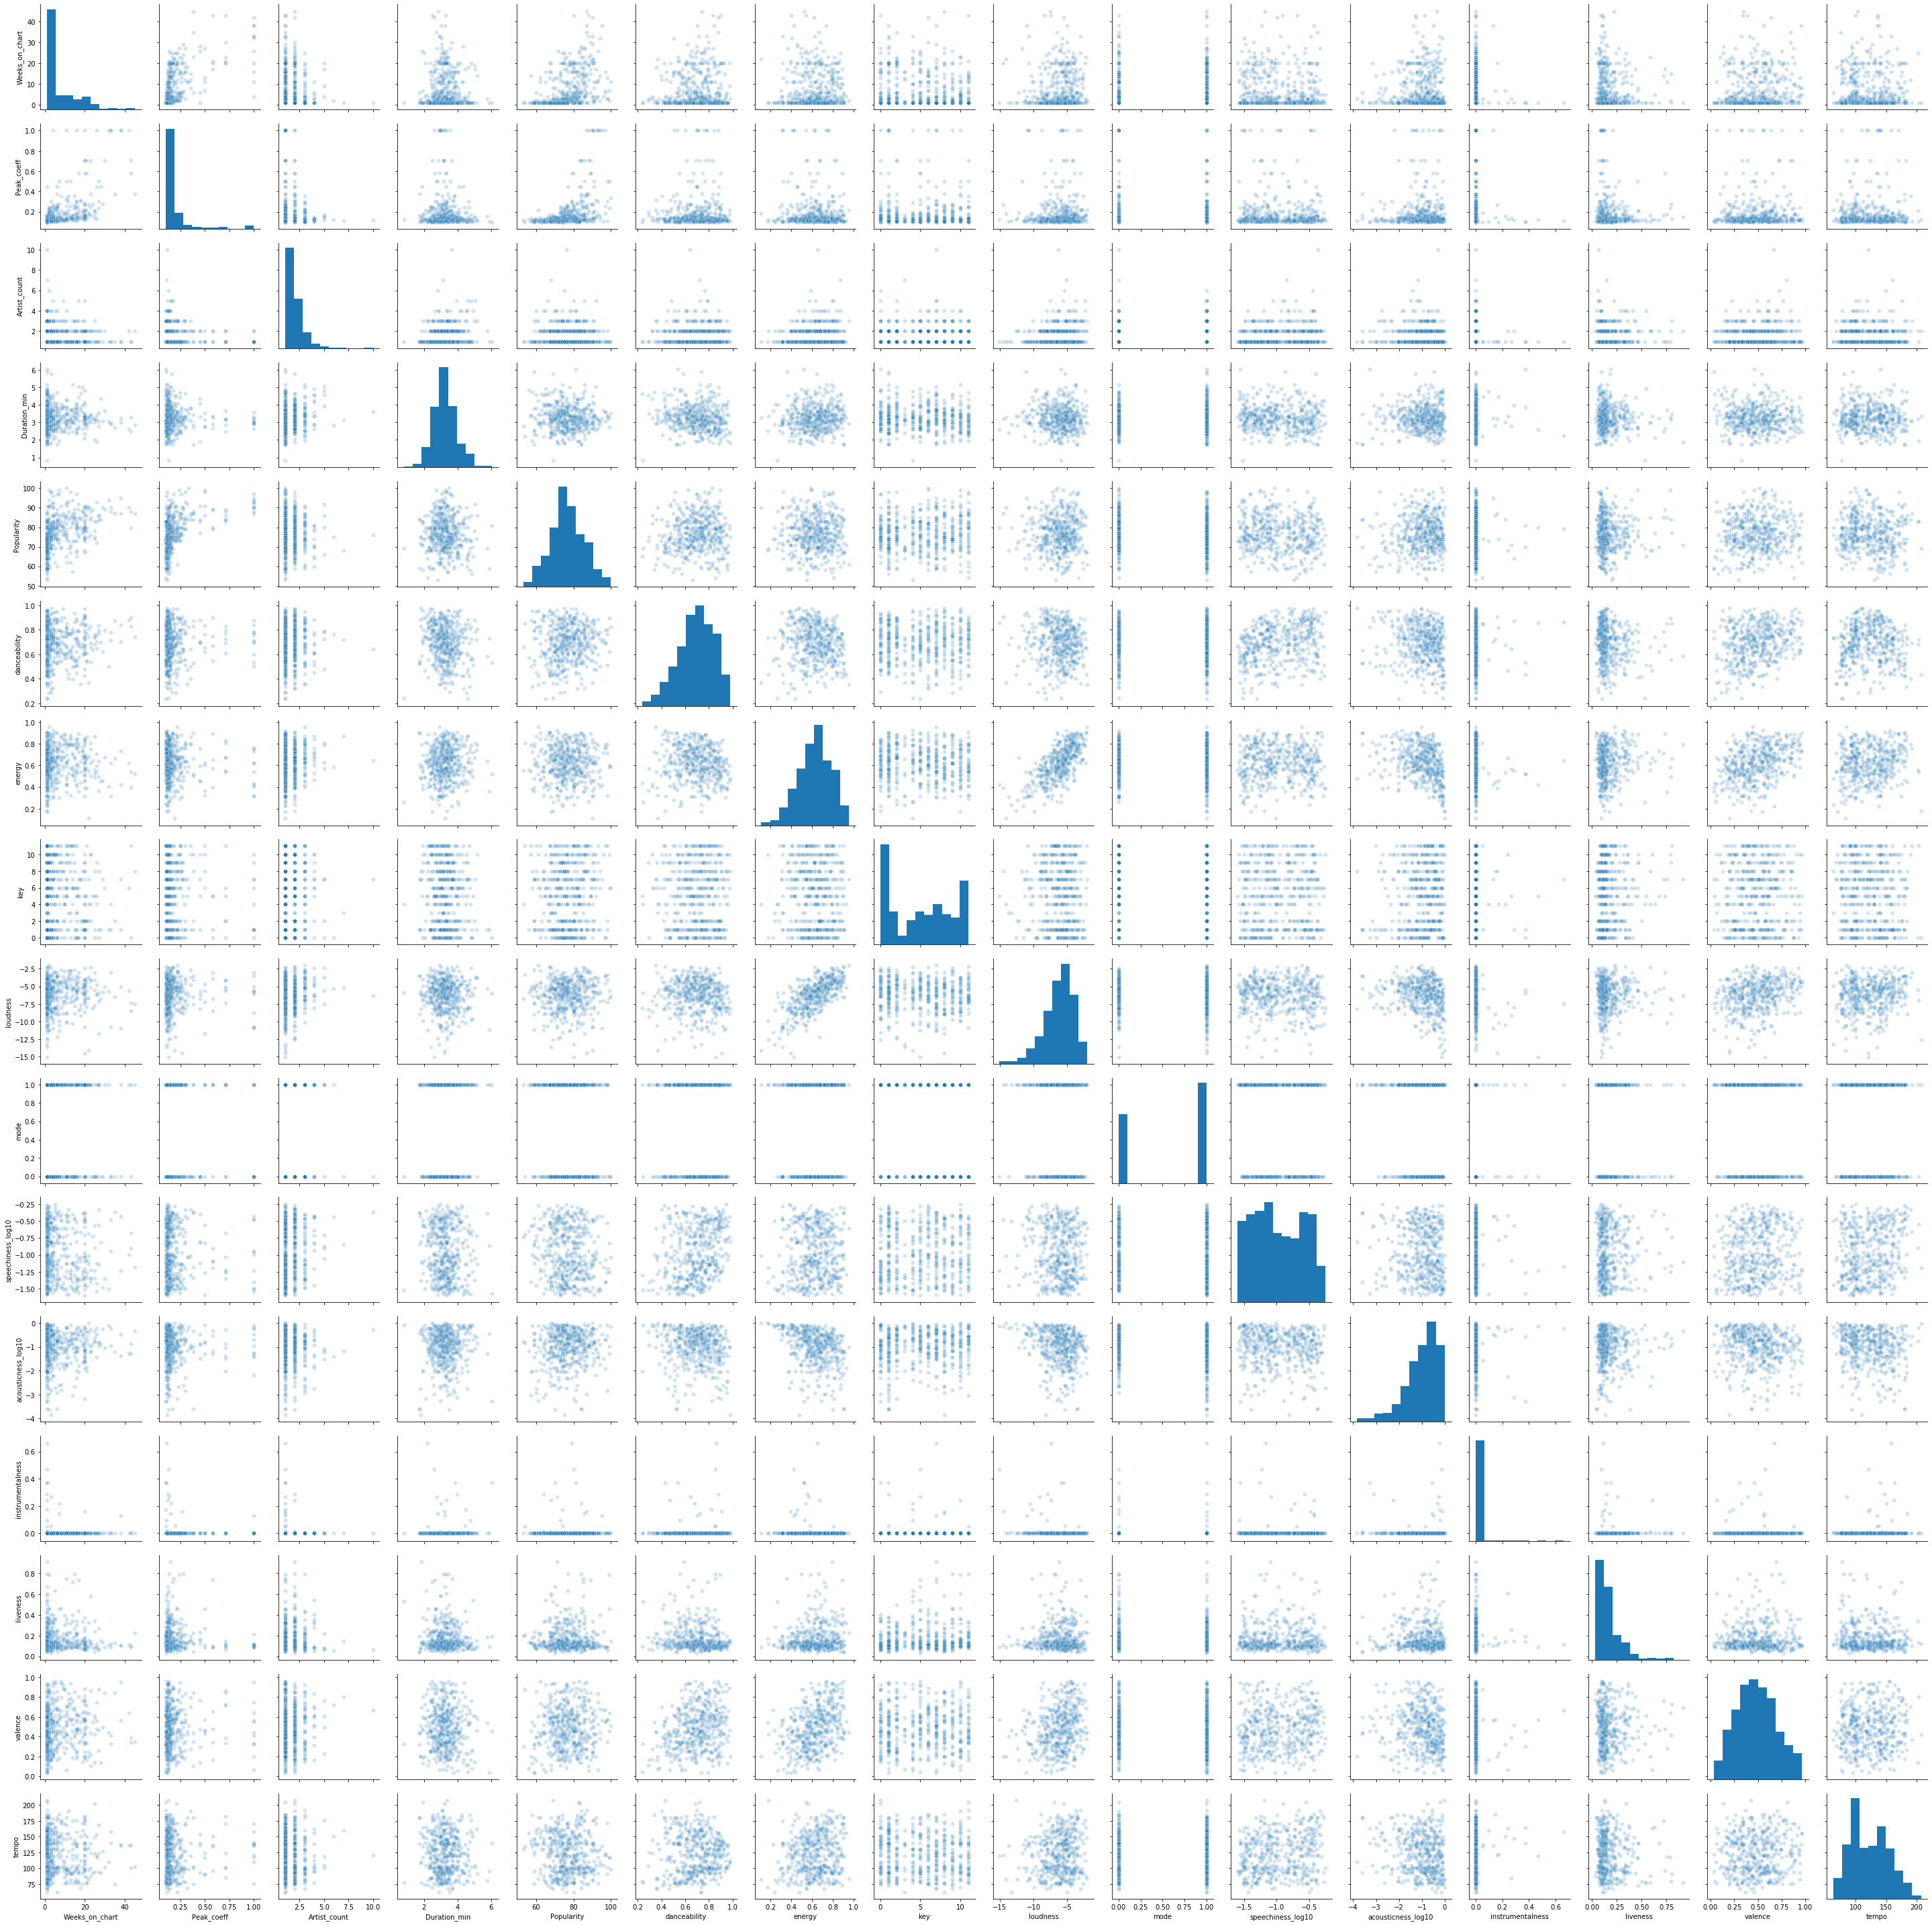

In [19]:
mask = released_2019[['Weeks_on_chart', 'Peak_coeff',
       'Artist_count', 'Duration_min', 'Popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness_log10',
       'acousticness_log10', 'instrumentalness', 'liveness', 'valence', 'tempo']]

sns.pairplot(mask, plot_kws={'alpha': 0.2})

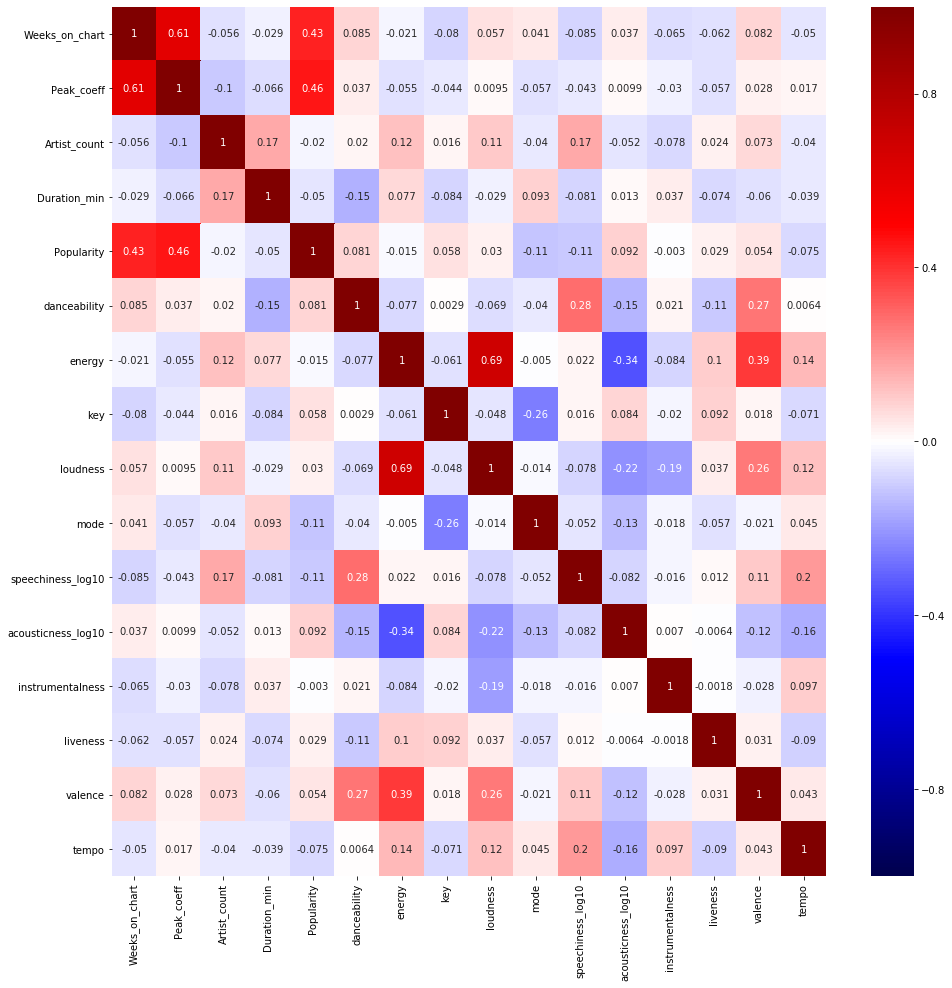

In [20]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(mask.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [21]:
mask = released_2019[['Weeks_on_chart', 'Peak_coeff',
       'Artist_count', 'Duration_min', 'Popularity',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness_log10',
       'acousticness_log10', 'instrumentalness', 'liveness', 'valence', 'tempo']]


y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Artist_count + 
                          Duration_min + Popularity + danceability + energy + key + loudness + 
                          mode + speechiness_log10 + acousticness_log10 + instrumentalness + liveness + 
                          tempo + valence''',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())

print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     21.25
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           5.19e-43
Time:                        23:57:05   Log-Likelihood:                -1479.4
No. Observations:                 448   AIC:                             2991.
Df Residuals:                     432   BIC:                             3056.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -12.3285      5

Ah, how wonderful, these changes have miraculously made things slightly worse.

I'm going to pull some features that seem unrelated based on my correlation plot.  Let's remove 'key' and 'mode' on the basis that they are more categorical than continuous, as well as 'instrumentalness' and 'liveness'.  Let's also revert 'acousticness' and 'speechiness'.

In [22]:
mask = released_2019[['Weeks_on_chart', 'Peak_coeff',
       'Artist_count', 'Duration_min', 'Popularity',
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'valence', 'tempo']]


y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Artist_count + 
                          Duration_min + Popularity + danceability + energy + loudness + 
                          speechiness + acousticness + tempo + valence''',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())

print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     27.89
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           4.72e-44
Time:                        23:57:06   Log-Likelihood:                -1483.8
No. Observations:                 448   AIC:                             2992.
Df Residuals:                     436   BIC:                             3041.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.5433      5.043     -1.496   

Hrm.  Let's see what these are about.

Perhaps popping out the variables with the most egregious P-scores will give us some clarity

In [23]:
mask = released_2019[['Weeks_on_chart', 'Peak_coeff',
       'Popularity', 'danceability', 'energy', 'speechiness',
       'acousticness', 'valence']]

y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff +  
                          Popularity + danceability + energy +  
                          speechiness + acousticness + valence''',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())

print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     43.26
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           2.20e-46
Time:                        23:57:06   Log-Likelihood:                -1485.9
No. Observations:                 448   AIC:                             2988.
Df Residuals:                     440   BIC:                             3021.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -11.8423      3.818     -3.102   

R^2 down, adjusted R^2 up, very slight reduction in rmse and mae

Move to LASSO to remove some nonessential variables.

In [24]:
y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff +  
                          Popularity + danceability + energy +  
                          speechiness + acousticness + valence''',
                       data=mask, return_type="dataframe")

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=5678)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=5678)

std = StandardScaler()
X_train_scaled = std.fit_transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
X_test_scaled = std.transform(X_test.values)

In [25]:
X_train.shape

(268, 8)

In [26]:
pd.DataFrame(X_train_scaled).describe()

0             1             2             3             4  \
count  268.0  2.680000e+02  2.680000e+02  2.680000e+02  2.680000e+02   
mean     0.0 -9.213194e-16  5.319128e-16 -1.246101e-15 -9.942296e-17   
std      0.0  1.001871e+00  1.001871e+00  1.001871e+00  1.001871e+00   
min      0.0 -5.185301e-01 -2.606544e+00 -3.011736e+00 -3.335081e+00   
25%      0.0 -4.492907e-01 -6.619862e-01 -6.925871e-01 -6.583353e-01   
50%      0.0 -3.546589e-01 -9.005744e-02  5.218712e-02  9.359569e-02   
75%      0.0 -1.018422e-01  7.106428e-01  7.901752e-01  7.571587e-01   
max      0.0  4.192451e+00  2.426429e+00  1.894613e+00  1.793474e+00   

                  5             6             7  
count  2.680000e+02  2.680000e+02  2.680000e+02  
mean   2.850125e-16 -4.606597e-16  1.362095e-15  
std    1.001871e+00  1.001871e+00  1.001871e+00  
min   -9.402780e-01 -9.528944e-01 -2.032049e+00  
25%   -7.731032e-01 -7.918782e-01 -7.259880e-01  
50%   -4.838828e-01 -4.216800e-01 -1.285493e-01  
75%    6.620106e-01  4.963950e-01  6.684200e-01  
max    3.014624e+00  3.050015e+00  2.185084e+00

In [27]:
import pprint
for i in range(-3,1):
    lasso_model = Lasso(alpha =10**i )
    lasso_model.fit(X_train_scaled, y_train)
    pprint.pprint(list(zip(X.columns, lasso_model.coef_)))

[('Intercept', 0.0),
 ('Peak_coeff', 4.938654160447072),
 ('Popularity', 1.7157619227686274),
 ('danceability', 0.2383899332522738),
 ('energy', -0.5306330256966701),
 ('speechiness', -0.18322647397609473),
 ('acousticness', -0.9182024252909536),
 ('valence', 0.7054183414021807)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.936561108237017),
 ('Popularity', 1.7097614824995422),
 ('danceability', 0.23683514345370774),
 ('energy', -0.5055750602956925),
 ('speechiness', -0.17165154320321765),
 ('acousticness', -0.8984841782222318),
 ('valence', 0.690408371537982)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.914942704649341),
 ('Popularity', 1.6499964850768503),
 ('danceability', 0.22011027733307142),
 ('energy', -0.25710238667214186),
 ('speechiness', -0.056020975295602904),
 ('acousticness', -0.7021836833685005),
 ('valence', 0.5414297619612215)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.401585576937565),
 ('Popularity', 1.023568767272682),
 ('danceability', 0.0),
 ('energy', 0.0),
 ('speechiness', -0

Between 10^-1 and 10^0 seems to be where we lose the most features.

In [28]:
for i in range(-10,10):
    lasso_model = Lasso(alpha =10**(i/10))
    lasso_model.fit(X_train_scaled, y_train)
    pprint.pprint(list(zip(X.columns, lasso_model.coef_)))

[('Intercept', 0.0),
 ('Peak_coeff', 4.914942704649341),
 ('Popularity', 1.6499964850768503),
 ('danceability', 0.22011027733307142),
 ('energy', -0.25710238667214186),
 ('speechiness', -0.056020975295602904),
 ('acousticness', -0.7021836833685005),
 ('valence', 0.5414297619612215)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.9086894991760825),
 ('Popularity', 1.6328141597834451),
 ('danceability', 0.21524131263082355),
 ('energy', -0.18572070672710272),
 ('speechiness', -0.022760432265439466),
 ('acousticness', -0.6457520195227153),
 ('valence', 0.4986239774997493)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.901033474004929),
 ('Popularity', 1.6087297913854062),
 ('danceability', 0.2128109035774278),
 ('energy', -0.09680928953725255),
 ('speechiness', -0.0),
 ('acousticness', -0.5757974558851994),
 ('valence', 0.4451836919146167)]
[('Intercept', 0.0),
 ('Peak_coeff', 4.890018763560187),
 ('Popularity', 1.5753848107881523),
 ('danceability', 0.21220396133182304),
 ('energy', -0.0),
 ('speechine

In order of elimination:

speechiness

energy

danceability

acousticness/valence

Popularity

Peak_coeff

In [29]:
mask = released_2019[['Weeks_on_chart', 'Peak_coeff',
       'Artist_count', 'Duration_min', 'Popularity',
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'valence', 'tempo']]

y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Popularity + acousticness + valence +
                          danceability + energy + speechiness''',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     43.26
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           2.20e-46
Time:                        23:57:07   Log-Likelihood:                -1485.9
No. Observations:                 448   AIC:                             2988.
Df Residuals:                     440   BIC:                             3021.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -11.8423      3.818     -3.102   

In [30]:
y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Popularity + acousticness + valence +
                          danceability + energy''',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     50.00
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           8.19e-47
Time:                        23:57:07   Log-Likelihood:                -1486.9
No. Observations:                 448   AIC:                             2988.
Df Residuals:                     441   BIC:                             3017.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -12.5946      3.786     -3.327   

In [31]:
y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Popularity + acousticness + valence +
                          danceability''',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     59.93
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.37e-47
Time:                        23:57:07   Log-Likelihood:                -1487.2
No. Observations:                 448   AIC:                             2986.
Df Residuals:                     442   BIC:                             3011.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -14.1036      3.273     -4.309   

In [32]:
y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff + Popularity + acousticness + valence',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     74.81
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           2.04e-48
Time:                        23:57:08   Log-Likelihood:                -1487.6
No. Observations:                 448   AIC:                             2985.
Df Residuals:                     443   BIC:                             3006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -13.1347      3.041     -4.319   

In [33]:
y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff + Popularity + acousticness',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     99.07
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           4.17e-49
Time:                        23:57:08   Log-Likelihood:                -1488.4
No. Observations:                 448   AIC:                             2985.
Df Residuals:                     444   BIC:                             3001.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -12.3224      2.975     -4.142   

In [34]:
y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff + Popularity',
                          data=mask, return_type="dataframe")


# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     147.0
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           9.58e-50
Time:                        23:57:08   Log-Likelihood:                -1489.5
No. Observations:                 448   AIC:                             2985.
Df Residuals:                     445   BIC:                             2997.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.6085      2.973     -4.241      0.0

In [35]:
y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     258.8
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           2.96e-46
Time:                        23:57:08   Log-Likelihood:                -1500.7
No. Observations:                 448   AIC:                             3005.
Df Residuals:                     446   BIC:                             3014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3507      0.496      2.723      0.0

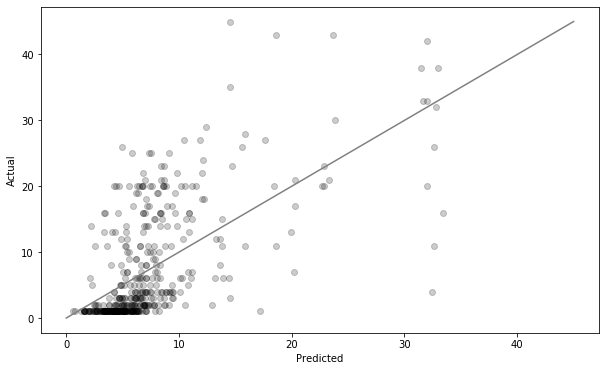

In [36]:
y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff + Popularity',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

plt.figure(figsize=(10,6))
plt.scatter(fit.predict(), y, alpha=.2,color='black');
plt.plot(np.linspace(0,45,2),np.linspace(0,45,2),color='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('2_feature.png',format ='png')

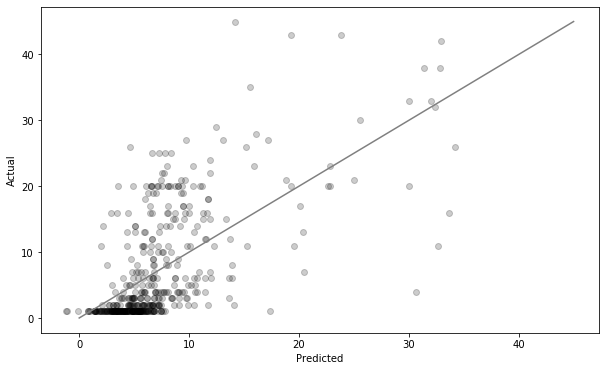

In [37]:
y, X = patsy.dmatrices('''Weeks_on_chart ~ Peak_coeff + Artist_count + 
                          Popularity + danceability + energy + loudness + 
                          speechiness + acousticness + valence + tempo''',
                       data=mask, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

plt.figure(figsize=(10,6))
plt.scatter(fit.predict(), y, alpha=.2,color='black');
plt.plot(np.linspace(0,45,2),np.linspace(0,45,2),color='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('kitchen_sink.png',format ='png')


All these models behaved almost identically, so I'm going to say we should keep it simple and use the model with just Popularity and Peak_coeff.

In [38]:
mask = released_2019[['Weeks_on_chart','Peak_coeff','Popularity']]

y, X = patsy.dmatrices('Weeks_on_chart ~ Peak_coeff + Popularity',
                          data=mask, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=5678)

lm = LinearRegression()

cross_val_score(lm, X_train, y_train, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric



array([0.39422946, 0.44065647, 0.31766777, 0.31748163, 0.41535414])

In [39]:
model = sm.OLS(y_test,X_test)
fit = model.fit()
print(fit.summary())
print('rmse: ',rmse(y,fit.predict()).mean())
print('mae: ',meanabs(y,fit.predict()).mean())

                            OLS Regression Results                            
Dep. Variable:         Weeks_on_chart   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     30.19
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.10e-10
Time:                        23:57:10   Log-Likelihood:                -291.50
No. Observations:                  90   AIC:                             589.0
Df Residuals:                      87   BIC:                             596.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.5175      5.882     -2.638      0.0